In [191]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [192]:
df = pd.read_csv('C:/Users/150ho/Desktop/data analyst/4. Машинное обучение/lesson2/1/GAZP_210801_220806.txt')

In [193]:
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,D,20210802,0,287.88,289.48,285.21,286.75,38297270
1,GAZP,D,20210803,0,286.77,288.05,284.34,287.09,27065240
2,GAZP,D,20210804,0,287.89,288.80,286.00,287.94,23599750
3,GAZP,D,20210805,0,287.31,288.28,285.16,285.95,47254880
4,GAZP,D,20210806,0,285.26,285.72,277.87,282.27,90600850
...,...,...,...,...,...,...,...,...,...
233,GAZP,D,20220801,0,194.50,194.69,192.00,192.00,13034930
234,GAZP,D,20220802,0,191.56,191.68,186.80,187.16,24267570
235,GAZP,D,20220803,0,187.59,188.97,186.31,187.04,12005960
236,GAZP,D,20220804,0,187.04,187.22,184.30,184.90,13313950


In [194]:
df.columns = ['TICKER','PER', 'ds', 'TIME', 'OPEN', 'HIGH', 'LOW', 'y', 'VOL']

In [195]:
df

,TICKER,PER,ds,TIME,OPEN,HIGH,LOW,y,VOL
0,GAZP,D,20210802,0,287.88,289.48,285.21,286.75,38297270
1,GAZP,D,20210803,0,286.77,288.05,284.34,287.09,27065240
2,GAZP,D,20210804,0,287.89,288.80,286.00,287.94,23599750
3,GAZP,D,20210805,0,287.31,288.28,285.16,285.95,47254880
4,GAZP,D,20210806,0,285.26,285.72,277.87,282.27,90600850
...,...,...,...,...,...,...,...,...,...
233,GAZP,D,20220801,0,194.50,194.69,192.00,192.00,13034930
234,GAZP,D,20220802,0,191.56,191.68,186.80,187.16,24267570
235,GAZP,D,20220803,0,187.59,188.97,186.31,187.04,12005960
236,GAZP,D,20220804,0,187.04,187.22,184.30,184.90,13313950


In [196]:
df['ds']

0      20210802
1      20210803
2      20210804
3      20210805
4      20210806
         ...   
233    20220801
234    20220802
235    20220803
236    20220804
237    20220805
Name: ds, Length: 238, dtype: int64

In [197]:
df['ds'] = pd.to_datetime(df['ds'], format='%Y%m%d')#,dayfirst=True)

In [198]:
df['ds']

0     2021-08-02
1     2021-08-03
2     2021-08-04
3     2021-08-05
4     2021-08-06
         ...    
233   2022-08-01
234   2022-08-02
235   2022-08-03
236   2022-08-04
237   2022-08-05
Name: ds, Length: 238, dtype: datetime64[ns]

In [199]:
df1 = df[['ds','y']]

In [200]:
df1.set_index('ds', inplace=True)
df1.sort_index(inplace=True)
print('Монотонность - ',df1.index.is_monotonic)

Монотонность -  True


In [201]:
df1

,y
ds,
2021-08-02,286.75
2021-08-03,287.09
2021-08-04,287.94
2021-08-05,285.95
2021-08-06,282.27
...,...
2022-08-01,192.00
2022-08-02,187.16
2022-08-03,187.04


<AxesSubplot:xlabel='ds'>

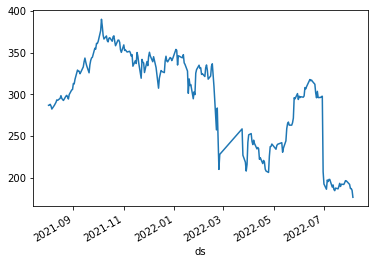

In [202]:
df1.y.plot()

<AxesSubplot:xlabel='ds'>

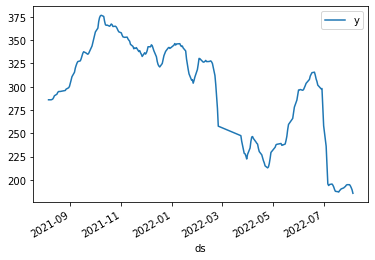

In [203]:
df1.rolling(5).mean().plot()

In [204]:
# функция по созданию сгенерированных признаков
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['y'].shift(lag)

    data['y_mean'] = data['y'].shift().rolling(rolling_mean_size).mean().copy()

In [205]:
make_features(df1, 7, 3)

In [206]:
df1

,y,year,month,day,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,y_mean
ds,,,,,,,,,,,,,,
2021-08-02,286.75,2021,8,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-03,287.09,2021,8,3,1,0,286.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-04,287.94,2021,8,4,2,0,287.09,286.75,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-05,285.95,2021,8,5,3,0,287.94,287.09,286.75,NaN,NaN,NaN,NaN,287.260000
2021-08-06,282.27,2021,8,6,4,0,285.95,287.94,287.09,286.75,NaN,NaN,NaN,286.993333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,192.00,2022,8,1,0,0,195.26,196.25,196.49,193.95,192.00,192.25,189.59,196.000000
2022-08-02,187.16,2022,8,2,1,0,192.00,195.26,196.25,196.49,193.95,192.00,192.25,194.503333
2022-08-03,187.04,2022,8,3,2,0,187.16,192.00,195.26,196.25,196.49,193.95,192.00,191.473333


In [207]:
df1.dropna(inplace=True)

In [208]:
df1

,y,year,month,day,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,y_mean
ds,,,,,,,,,,,,,,
2021-08-11,290.35,2021,8,11,2,0,288.61,286.68,282.27,285.95,287.94,287.09,286.75,285.853333
2021-08-12,293.23,2021,8,12,3,0,290.35,288.61,286.68,282.27,285.95,287.94,287.09,288.546667
2021-08-13,292.70,2021,8,13,4,0,293.23,290.35,288.61,286.68,282.27,285.95,287.94,290.730000
2021-08-16,295.10,2021,8,16,0,0,292.70,293.23,290.35,288.61,286.68,282.27,285.95,292.093333
2021-08-17,298.32,2021,8,17,1,0,295.10,292.70,293.23,290.35,288.61,286.68,282.27,293.676667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,192.00,2022,8,1,0,0,195.26,196.25,196.49,193.95,192.00,192.25,189.59,196.000000
2022-08-02,187.16,2022,8,2,1,0,192.00,195.26,196.25,196.49,193.95,192.00,192.25,194.503333
2022-08-03,187.04,2022,8,3,2,0,187.16,192.00,195.26,196.25,196.49,193.95,192.00,191.473333


In [209]:
features = df1.drop(['y'],axis = 1)
target = df1['y']
X_train,X_test,y_train, y_test = train_test_split(features,target, shuffle=False, test_size=0.25)
print('X_train',X_train.shape)
print('X_test',X_test.shape)

X_train (173, 13)
X_test (58, 13)


In [210]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

LinearRegression()

In [211]:
y_predicted_lr = model_lr.predict(X_test)

In [212]:
y_predicted_lr

array([244.19233229, 256.00841739, 260.40801267, 261.58802053,
       264.30333786, 264.21460192, 265.78988248, 268.47649509,
       285.79192891, 292.51514519, 295.33351871, 291.77019677,
       295.53755248, 294.11262519, 295.28800469, 293.51156338,
       293.42192607, 301.11798185, 301.01452587, 304.31757364,
       310.43043646, 311.94662542, 310.53487564, 311.59230649,
       309.36217203, 299.62168747, 291.45954988, 295.81551813,
       294.82613741, 290.6415951 , 290.28832989, 292.61875427,
       224.32369413, 194.88581349, 192.89859313, 202.12280224,
       188.84334797, 185.24340702, 198.64771686, 194.36794898,
       193.96326899, 189.25278051, 186.49415501, 189.94493974,
       189.6172382 , 190.87129437, 192.90406539, 191.15009811,
       195.02257861, 194.82267912, 196.09455412, 196.71398655,
       196.08122761, 199.16084041, 195.62297355, 190.99031375,
       188.99573107, 186.4760259 ])

In [213]:
print("RMSE тестовой выборки LinearRegression: ",np.sqrt(mean_squared_error(y_test, y_predicted_lr)))

RMSE тестовой выборки LinearRegression:  14.039845196108528


In [214]:
df1_with_predict = X_test
df1_with_predict['y'] = y_test
df1_with_predict['y_predicted_lr'] = y_predicted_lr
df1_with_predict[['y','y_predicted_lr']].tail(10)

,y,y_predicted_lr
ds,,
2022-07-25,192.00,195.022579
2022-07-26,193.95,194.822679
2022-07-27,196.49,196.094554
2022-07-28,196.25,196.713987
2022-07-29,195.26,196.081228
2022-08-01,192.00,199.160840
2022-08-02,187.16,195.622974
2022-08-03,187.04,190.990314
2022-08-04,184.90,188.995731


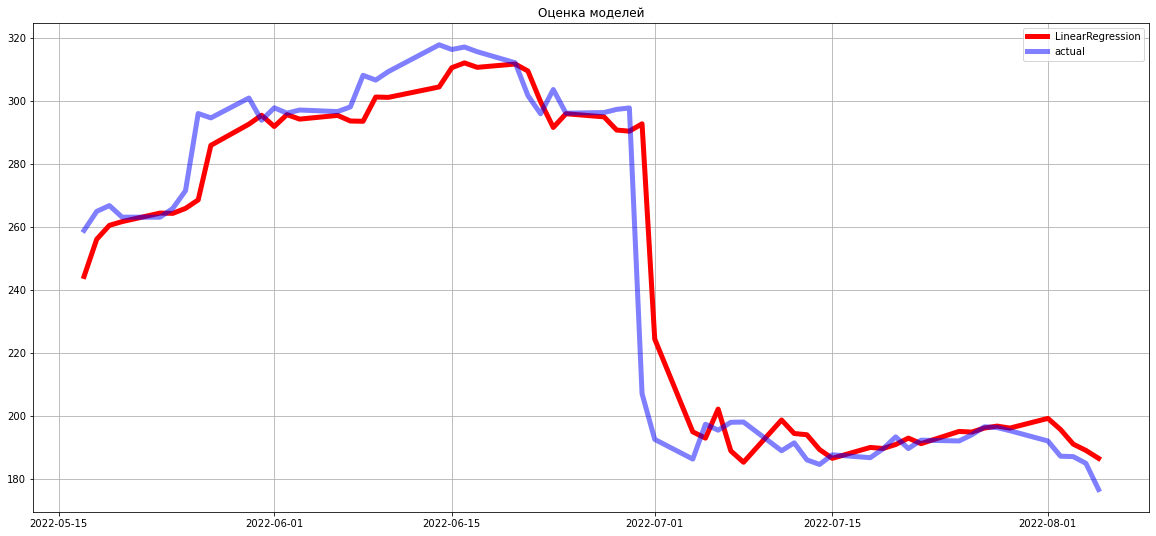

In [215]:
plt.figure(figsize=(20, 9))
plt.plot(df1_with_predict['y_predicted_lr'], "r",linewidth=5, label="LinearRegression")
plt.plot(df1_with_predict['y'],'b' ,label="actual", linewidth=5, alpha = 0.5)
plt.legend(loc="best")
plt.title("Оценка моделей")
plt.grid(True);

## Используем Facebok

In [216]:
# conda install -c conda-forge prophet

In [217]:
# https://facebook.github.io/prophet/
from prophet import Prophet

In [218]:
m = Prophet()

In [219]:
df_prophet = df[['ds', 'y']]

In [220]:
df_prophet

,ds,y
0,2021-08-02,286.75
1,2021-08-03,287.09
2,2021-08-04,287.94
3,2021-08-05,285.95
4,2021-08-06,282.27
...,...,...
233,2022-08-01,192.00
234,2022-08-02,187.16
235,2022-08-03,187.04
236,2022-08-04,184.90


In [221]:
# df_prophet.reset_index(inplace=True)

In [222]:
# df_prophet

In [223]:
m.add_country_holidays(country_name='RU')
m.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [224]:
future = m.make_future_dataframe(periods=7)
future.tail(7)

,ds
238,2022-08-06
239,2022-08-07
240,2022-08-08
241,2022-08-09
242,2022-08-10
243,2022-08-11
244,2022-08-12


In [225]:
forecast = m.predict(future)

In [226]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Defender of the Fatherland Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-08-02,305.442017,268.392432,347.723813,305.442017,305.442017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.938683,1.938683,1.938683,0.0,0.0,0.0,307.380701
1,2021-08-03,305.925330,271.970818,354.869639,305.925330,305.925330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.374273,6.374273,6.374273,0.0,0.0,0.0,312.299602
2,2021-08-04,306.408642,272.683800,352.406628,306.408642,306.408642,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.392410,7.392410,7.392410,0.0,0.0,0.0,313.801052
3,2021-08-05,306.891955,267.564792,346.083942,306.891955,306.891955,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.120845,3.120845,3.120845,0.0,0.0,0.0,310.012800
4,2021-08-06,307.375268,268.301612,349.230344,307.375268,307.375268,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.541218,0.541218,0.541218,0.0,0.0,0.0,307.916486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2022-08-08,205.294340,167.508163,243.484061,205.292032,205.295649,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.938683,1.938683,1.938683,0.0,0.0,0.0,207.233023
241,2022-08-09,204.764378,168.312457,252.266991,204.746148,204.783627,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.374273,6.374273,6.374273,0.0,0.0,0.0,211.138651
242,2022-08-10,204.234417,174.636577,251.206949,204.204581,204.283486,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.392410,7.392410,7.392410,0.0,0.0,0.0,211.626827
243,2022-08-11,203.704456,165.239940,244.931786,203.649218,203.788233,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.120845,3.120845,3.120845,0.0,0.0,0.0,206.825301


In [227]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
235,2022-08-03,215.336556,174.719936,252.991037
236,2022-08-04,210.535030,169.813847,249.884370
237,2022-08-05,207.425441,168.063111,248.221817
238,2022-08-06,196.670547,153.986214,238.684837
239,2022-08-07,196.140586,156.499387,235.452495
240,2022-08-08,207.233023,167.508163,243.484061
241,2022-08-09,211.138651,168.312457,252.266991
242,2022-08-10,211.626827,174.636577,251.206949
243,2022-08-11,206.825301,165.239940,244.931786
244,2022-08-12,203.715713,161.740454,244.191567


In [228]:
forecast.set_index('ds', inplace=True)

<AxesSubplot:xlabel='ds'>

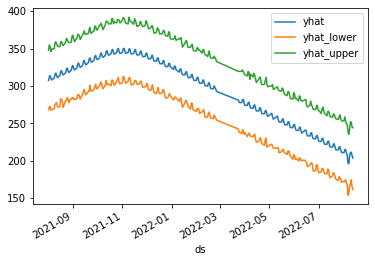

In [229]:
forecast[[ 'yhat', 'yhat_lower', 'yhat_upper']].plot()

In [230]:
print("RMSE on Prophet: ",np.sqrt(mean_squared_error(df['y'], forecast.yhat[:238])))

RMSE on Prophet:  31.548555600353943


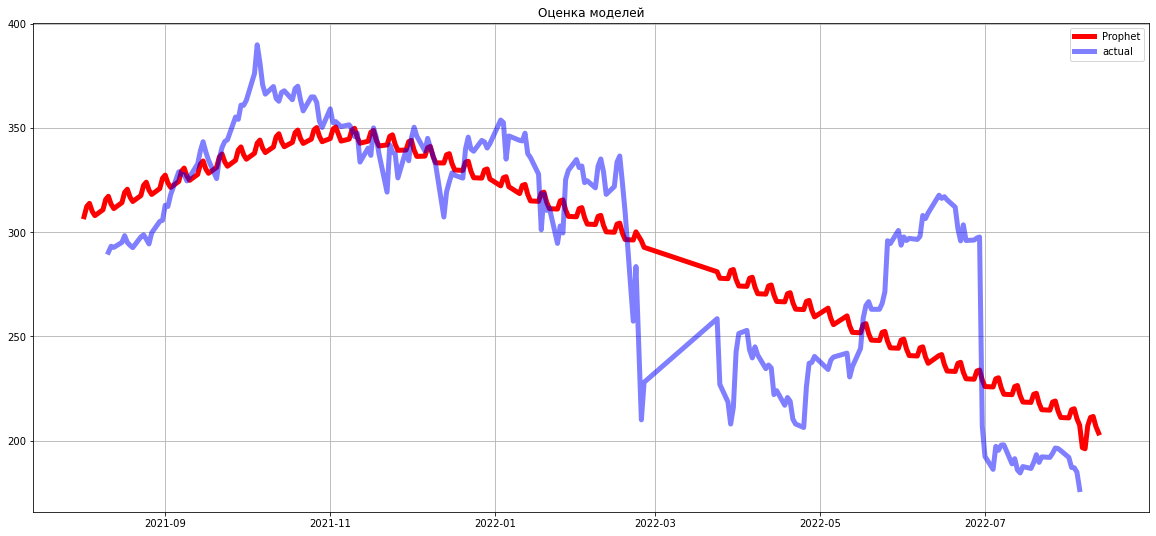

In [231]:
plt.figure(figsize=(20, 9))
plt.plot(forecast['yhat'], "r",linewidth=5, label="Prophet")
plt.plot(df1['y'],'b' ,label="actual", linewidth=5, alpha = 0.5)
plt.legend(loc="best")
plt.title("Оценка моделей")
plt.grid(True);

# Сравниваем результаты

In [236]:
df1_with_predict = X_test
df1_with_predict['y'] = y_test
df1_with_predict['y_predicted_lr'] = y_predicted_lr
df1_with_predict['y_prophet'] = forecast.yhat[180:238]
df1_with_predict[['y','y_predicted_lr', 'y_prophet']].tail()

,y,y_predicted_lr,y_prophet
ds,,,
2022-08-01,192.00,199.160840,210.942752
2022-08-02,187.16,195.622974,214.848380
2022-08-03,187.04,190.990314,215.336556
2022-08-04,184.90,188.995731,210.535030
2022-08-05,176.58,186.476026,207.425441


<AxesSubplot:xlabel='ds'>

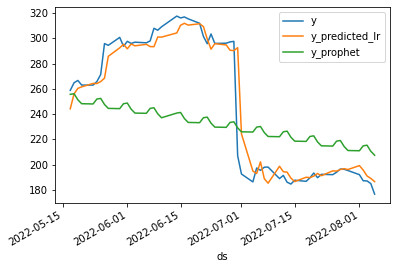

In [237]:
df1_with_predict[[ 'y', 'y_predicted_lr', 'y_prophet']].plot()

In [239]:
print("RMSE тестовой выборки LinearRegression: ",np.sqrt(mean_squared_error(y_test, y_predicted_lr)))
print("RMSE тестовой выборки Prophet: ",np.sqrt(mean_squared_error(y_test, forecast.yhat[180:238])))

RMSE тестовой выборки LinearRegression:  14.039845196108528
RMSE тестовой выборки Prophet:  45.9979331546485
